## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

input_image_size = 224
depth = 1

# Instantiate the network
from models import Net

net = Net(input_image_size, depth)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=4096, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=4096, out_features=1028, bias=True)
  (output): Linear(in_features=1028, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [50]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [51]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Normalize, ToTensor, RandomCrop, Rescale


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(input_image_size+16),
                                     RandomCrop(input_image_size),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [52]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    assert sample['image'].size() == (depth, input_image_size, input_image_size)

Number of images:  3452
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
5 torch.Size([1, 224, 224]) torch.Size([68, 2])
6 torch.Size([1, 224, 224]) torch.Size([68, 2])
7 torch.Size([1, 224, 224]) torch.Size([68, 2])
8 torch.Size([1, 224, 224]) torch.Size([68, 2])
9 torch.Size([1, 224, 224]) torch.Size([68, 2])
10 torch.Size([1, 224, 224]) torch.Size([68, 2])
11 torch.Size([1, 224, 224]) torch.Size([68, 2])
12 torch.Size([1, 224, 224]) torch.Size([68, 2])
13 torch.Size([1, 224, 224]) torch.Size([68, 2])
14 torch.Size([1, 224, 224]) torch.Size([68, 2])
15 torch.Size([1, 224, 224]) torch.Size([68, 2])
16 torch.Size([1, 224, 224]) torch.Size([68, 2])
17 torch.Size([1, 224, 224]) torch.Size([68, 2])
18 torch.Size([1, 224, 224]) torch.Size([68, 2])
19 torch.Size([1, 224, 224]) torch.Size([68, 2])
20 tor

209 torch.Size([1, 224, 224]) torch.Size([68, 2])
210 torch.Size([1, 224, 224]) torch.Size([68, 2])
211 torch.Size([1, 224, 224]) torch.Size([68, 2])
212 torch.Size([1, 224, 224]) torch.Size([68, 2])
213 torch.Size([1, 224, 224]) torch.Size([68, 2])
214 torch.Size([1, 224, 224]) torch.Size([68, 2])
215 torch.Size([1, 224, 224]) torch.Size([68, 2])
216 torch.Size([1, 224, 224]) torch.Size([68, 2])
217 torch.Size([1, 224, 224]) torch.Size([68, 2])
218 torch.Size([1, 224, 224]) torch.Size([68, 2])
219 torch.Size([1, 224, 224]) torch.Size([68, 2])
220 torch.Size([1, 224, 224]) torch.Size([68, 2])
221 torch.Size([1, 224, 224]) torch.Size([68, 2])
222 torch.Size([1, 224, 224]) torch.Size([68, 2])
223 torch.Size([1, 224, 224]) torch.Size([68, 2])
224 torch.Size([1, 224, 224]) torch.Size([68, 2])
225 torch.Size([1, 224, 224]) torch.Size([68, 2])
226 torch.Size([1, 224, 224]) torch.Size([68, 2])
227 torch.Size([1, 224, 224]) torch.Size([68, 2])
228 torch.Size([1, 224, 224]) torch.Size([68, 2])


414 torch.Size([1, 224, 224]) torch.Size([68, 2])
415 torch.Size([1, 224, 224]) torch.Size([68, 2])
416 torch.Size([1, 224, 224]) torch.Size([68, 2])
417 torch.Size([1, 224, 224]) torch.Size([68, 2])
418 torch.Size([1, 224, 224]) torch.Size([68, 2])
419 torch.Size([1, 224, 224]) torch.Size([68, 2])
420 torch.Size([1, 224, 224]) torch.Size([68, 2])
421 torch.Size([1, 224, 224]) torch.Size([68, 2])
422 torch.Size([1, 224, 224]) torch.Size([68, 2])
423 torch.Size([1, 224, 224]) torch.Size([68, 2])
424 torch.Size([1, 224, 224]) torch.Size([68, 2])
425 torch.Size([1, 224, 224]) torch.Size([68, 2])
426 torch.Size([1, 224, 224]) torch.Size([68, 2])
427 torch.Size([1, 224, 224]) torch.Size([68, 2])
428 torch.Size([1, 224, 224]) torch.Size([68, 2])
429 torch.Size([1, 224, 224]) torch.Size([68, 2])
430 torch.Size([1, 224, 224]) torch.Size([68, 2])
431 torch.Size([1, 224, 224]) torch.Size([68, 2])
432 torch.Size([1, 224, 224]) torch.Size([68, 2])
433 torch.Size([1, 224, 224]) torch.Size([68, 2])


613 torch.Size([1, 224, 224]) torch.Size([68, 2])
614 torch.Size([1, 224, 224]) torch.Size([68, 2])
615 torch.Size([1, 224, 224]) torch.Size([68, 2])
616 torch.Size([1, 224, 224]) torch.Size([68, 2])
617 torch.Size([1, 224, 224]) torch.Size([68, 2])
618 torch.Size([1, 224, 224]) torch.Size([68, 2])
619 torch.Size([1, 224, 224]) torch.Size([68, 2])
620 torch.Size([1, 224, 224]) torch.Size([68, 2])
621 torch.Size([1, 224, 224]) torch.Size([68, 2])
622 torch.Size([1, 224, 224]) torch.Size([68, 2])
623 torch.Size([1, 224, 224]) torch.Size([68, 2])
624 torch.Size([1, 224, 224]) torch.Size([68, 2])
625 torch.Size([1, 224, 224]) torch.Size([68, 2])
626 torch.Size([1, 224, 224]) torch.Size([68, 2])
627 torch.Size([1, 224, 224]) torch.Size([68, 2])
628 torch.Size([1, 224, 224]) torch.Size([68, 2])
629 torch.Size([1, 224, 224]) torch.Size([68, 2])
630 torch.Size([1, 224, 224]) torch.Size([68, 2])
631 torch.Size([1, 224, 224]) torch.Size([68, 2])
632 torch.Size([1, 224, 224]) torch.Size([68, 2])


816 torch.Size([1, 224, 224]) torch.Size([68, 2])
817 torch.Size([1, 224, 224]) torch.Size([68, 2])
818 torch.Size([1, 224, 224]) torch.Size([68, 2])
819 torch.Size([1, 224, 224]) torch.Size([68, 2])
820 torch.Size([1, 224, 224]) torch.Size([68, 2])
821 torch.Size([1, 224, 224]) torch.Size([68, 2])
822 torch.Size([1, 224, 224]) torch.Size([68, 2])
823 torch.Size([1, 224, 224]) torch.Size([68, 2])
824 torch.Size([1, 224, 224]) torch.Size([68, 2])
825 torch.Size([1, 224, 224]) torch.Size([68, 2])
826 torch.Size([1, 224, 224]) torch.Size([68, 2])
827 torch.Size([1, 224, 224]) torch.Size([68, 2])
828 torch.Size([1, 224, 224]) torch.Size([68, 2])
829 torch.Size([1, 224, 224]) torch.Size([68, 2])
830 torch.Size([1, 224, 224]) torch.Size([68, 2])
831 torch.Size([1, 224, 224]) torch.Size([68, 2])
832 torch.Size([1, 224, 224]) torch.Size([68, 2])
833 torch.Size([1, 224, 224]) torch.Size([68, 2])
834 torch.Size([1, 224, 224]) torch.Size([68, 2])
835 torch.Size([1, 224, 224]) torch.Size([68, 2])


1016 torch.Size([1, 224, 224]) torch.Size([68, 2])
1017 torch.Size([1, 224, 224]) torch.Size([68, 2])
1018 torch.Size([1, 224, 224]) torch.Size([68, 2])
1019 torch.Size([1, 224, 224]) torch.Size([68, 2])
1020 torch.Size([1, 224, 224]) torch.Size([68, 2])
1021 torch.Size([1, 224, 224]) torch.Size([68, 2])
1022 torch.Size([1, 224, 224]) torch.Size([68, 2])
1023 torch.Size([1, 224, 224]) torch.Size([68, 2])
1024 torch.Size([1, 224, 224]) torch.Size([68, 2])
1025 torch.Size([1, 224, 224]) torch.Size([68, 2])
1026 torch.Size([1, 224, 224]) torch.Size([68, 2])
1027 torch.Size([1, 224, 224]) torch.Size([68, 2])
1028 torch.Size([1, 224, 224]) torch.Size([68, 2])
1029 torch.Size([1, 224, 224]) torch.Size([68, 2])
1030 torch.Size([1, 224, 224]) torch.Size([68, 2])
1031 torch.Size([1, 224, 224]) torch.Size([68, 2])
1032 torch.Size([1, 224, 224]) torch.Size([68, 2])
1033 torch.Size([1, 224, 224]) torch.Size([68, 2])
1034 torch.Size([1, 224, 224]) torch.Size([68, 2])
1035 torch.Size([1, 224, 224]) 

1222 torch.Size([1, 224, 224]) torch.Size([68, 2])
1223 torch.Size([1, 224, 224]) torch.Size([68, 2])
1224 torch.Size([1, 224, 224]) torch.Size([68, 2])
1225 torch.Size([1, 224, 224]) torch.Size([68, 2])
1226 torch.Size([1, 224, 224]) torch.Size([68, 2])
1227 torch.Size([1, 224, 224]) torch.Size([68, 2])
1228 torch.Size([1, 224, 224]) torch.Size([68, 2])
1229 torch.Size([1, 224, 224]) torch.Size([68, 2])
1230 torch.Size([1, 224, 224]) torch.Size([68, 2])
1231 torch.Size([1, 224, 224]) torch.Size([68, 2])
1232 torch.Size([1, 224, 224]) torch.Size([68, 2])
1233 torch.Size([1, 224, 224]) torch.Size([68, 2])
1234 torch.Size([1, 224, 224]) torch.Size([68, 2])
1235 torch.Size([1, 224, 224]) torch.Size([68, 2])
1236 torch.Size([1, 224, 224]) torch.Size([68, 2])
1237 torch.Size([1, 224, 224]) torch.Size([68, 2])
1238 torch.Size([1, 224, 224]) torch.Size([68, 2])
1239 torch.Size([1, 224, 224]) torch.Size([68, 2])
1240 torch.Size([1, 224, 224]) torch.Size([68, 2])
1241 torch.Size([1, 224, 224]) 

1432 torch.Size([1, 224, 224]) torch.Size([68, 2])
1433 torch.Size([1, 224, 224]) torch.Size([68, 2])
1434 torch.Size([1, 224, 224]) torch.Size([68, 2])
1435 torch.Size([1, 224, 224]) torch.Size([68, 2])
1436 torch.Size([1, 224, 224]) torch.Size([68, 2])
1437 torch.Size([1, 224, 224]) torch.Size([68, 2])
1438 torch.Size([1, 224, 224]) torch.Size([68, 2])
1439 torch.Size([1, 224, 224]) torch.Size([68, 2])
1440 torch.Size([1, 224, 224]) torch.Size([68, 2])
1441 torch.Size([1, 224, 224]) torch.Size([68, 2])
1442 torch.Size([1, 224, 224]) torch.Size([68, 2])
1443 torch.Size([1, 224, 224]) torch.Size([68, 2])
1444 torch.Size([1, 224, 224]) torch.Size([68, 2])
1445 torch.Size([1, 224, 224]) torch.Size([68, 2])
1446 torch.Size([1, 224, 224]) torch.Size([68, 2])
1447 torch.Size([1, 224, 224]) torch.Size([68, 2])
1448 torch.Size([1, 224, 224]) torch.Size([68, 2])
1449 torch.Size([1, 224, 224]) torch.Size([68, 2])
1450 torch.Size([1, 224, 224]) torch.Size([68, 2])
1451 torch.Size([1, 224, 224]) 

1643 torch.Size([1, 224, 224]) torch.Size([68, 2])
1644 torch.Size([1, 224, 224]) torch.Size([68, 2])
1645 torch.Size([1, 224, 224]) torch.Size([68, 2])
1646 torch.Size([1, 224, 224]) torch.Size([68, 2])
1647 torch.Size([1, 224, 224]) torch.Size([68, 2])
1648 torch.Size([1, 224, 224]) torch.Size([68, 2])
1649 torch.Size([1, 224, 224]) torch.Size([68, 2])
1650 torch.Size([1, 224, 224]) torch.Size([68, 2])
1651 torch.Size([1, 224, 224]) torch.Size([68, 2])
1652 torch.Size([1, 224, 224]) torch.Size([68, 2])
1653 torch.Size([1, 224, 224]) torch.Size([68, 2])
1654 torch.Size([1, 224, 224]) torch.Size([68, 2])
1655 torch.Size([1, 224, 224]) torch.Size([68, 2])
1656 torch.Size([1, 224, 224]) torch.Size([68, 2])
1657 torch.Size([1, 224, 224]) torch.Size([68, 2])
1658 torch.Size([1, 224, 224]) torch.Size([68, 2])
1659 torch.Size([1, 224, 224]) torch.Size([68, 2])
1660 torch.Size([1, 224, 224]) torch.Size([68, 2])
1661 torch.Size([1, 224, 224]) torch.Size([68, 2])
1662 torch.Size([1, 224, 224]) 

1848 torch.Size([1, 224, 224]) torch.Size([68, 2])
1849 torch.Size([1, 224, 224]) torch.Size([68, 2])
1850 torch.Size([1, 224, 224]) torch.Size([68, 2])
1851 torch.Size([1, 224, 224]) torch.Size([68, 2])
1852 torch.Size([1, 224, 224]) torch.Size([68, 2])
1853 torch.Size([1, 224, 224]) torch.Size([68, 2])
1854 torch.Size([1, 224, 224]) torch.Size([68, 2])
1855 torch.Size([1, 224, 224]) torch.Size([68, 2])
1856 torch.Size([1, 224, 224]) torch.Size([68, 2])
1857 torch.Size([1, 224, 224]) torch.Size([68, 2])
1858 torch.Size([1, 224, 224]) torch.Size([68, 2])
1859 torch.Size([1, 224, 224]) torch.Size([68, 2])
1860 torch.Size([1, 224, 224]) torch.Size([68, 2])
1861 torch.Size([1, 224, 224]) torch.Size([68, 2])
1862 torch.Size([1, 224, 224]) torch.Size([68, 2])
1863 torch.Size([1, 224, 224]) torch.Size([68, 2])
1864 torch.Size([1, 224, 224]) torch.Size([68, 2])
1865 torch.Size([1, 224, 224]) torch.Size([68, 2])
1866 torch.Size([1, 224, 224]) torch.Size([68, 2])
1867 torch.Size([1, 224, 224]) 

2047 torch.Size([1, 224, 224]) torch.Size([68, 2])
2048 torch.Size([1, 224, 224]) torch.Size([68, 2])
2049 torch.Size([1, 224, 224]) torch.Size([68, 2])
2050 torch.Size([1, 224, 224]) torch.Size([68, 2])
2051 torch.Size([1, 224, 224]) torch.Size([68, 2])
2052 torch.Size([1, 224, 224]) torch.Size([68, 2])
2053 torch.Size([1, 224, 224]) torch.Size([68, 2])
2054 torch.Size([1, 224, 224]) torch.Size([68, 2])
2055 torch.Size([1, 224, 224]) torch.Size([68, 2])
2056 torch.Size([1, 224, 224]) torch.Size([68, 2])
2057 torch.Size([1, 224, 224]) torch.Size([68, 2])
2058 torch.Size([1, 224, 224]) torch.Size([68, 2])
2059 torch.Size([1, 224, 224]) torch.Size([68, 2])
2060 torch.Size([1, 224, 224]) torch.Size([68, 2])
2061 torch.Size([1, 224, 224]) torch.Size([68, 2])
2062 torch.Size([1, 224, 224]) torch.Size([68, 2])
2063 torch.Size([1, 224, 224]) torch.Size([68, 2])
2064 torch.Size([1, 224, 224]) torch.Size([68, 2])
2065 torch.Size([1, 224, 224]) torch.Size([68, 2])
2066 torch.Size([1, 224, 224]) 

2251 torch.Size([1, 224, 224]) torch.Size([68, 2])
2252 torch.Size([1, 224, 224]) torch.Size([68, 2])
2253 torch.Size([1, 224, 224]) torch.Size([68, 2])
2254 torch.Size([1, 224, 224]) torch.Size([68, 2])
2255 torch.Size([1, 224, 224]) torch.Size([68, 2])
2256 torch.Size([1, 224, 224]) torch.Size([68, 2])
2257 torch.Size([1, 224, 224]) torch.Size([68, 2])
2258 torch.Size([1, 224, 224]) torch.Size([68, 2])
2259 torch.Size([1, 224, 224]) torch.Size([68, 2])
2260 torch.Size([1, 224, 224]) torch.Size([68, 2])
2261 torch.Size([1, 224, 224]) torch.Size([68, 2])
2262 torch.Size([1, 224, 224]) torch.Size([68, 2])
2263 torch.Size([1, 224, 224]) torch.Size([68, 2])
2264 torch.Size([1, 224, 224]) torch.Size([68, 2])
2265 torch.Size([1, 224, 224]) torch.Size([68, 2])
2266 torch.Size([1, 224, 224]) torch.Size([68, 2])
2267 torch.Size([1, 224, 224]) torch.Size([68, 2])
2268 torch.Size([1, 224, 224]) torch.Size([68, 2])
2269 torch.Size([1, 224, 224]) torch.Size([68, 2])
2270 torch.Size([1, 224, 224]) 

2466 torch.Size([1, 224, 224]) torch.Size([68, 2])
2467 torch.Size([1, 224, 224]) torch.Size([68, 2])
2468 torch.Size([1, 224, 224]) torch.Size([68, 2])
2469 torch.Size([1, 224, 224]) torch.Size([68, 2])
2470 torch.Size([1, 224, 224]) torch.Size([68, 2])
2471 torch.Size([1, 224, 224]) torch.Size([68, 2])
2472 torch.Size([1, 224, 224]) torch.Size([68, 2])
2473 torch.Size([1, 224, 224]) torch.Size([68, 2])
2474 torch.Size([1, 224, 224]) torch.Size([68, 2])
2475 torch.Size([1, 224, 224]) torch.Size([68, 2])
2476 torch.Size([1, 224, 224]) torch.Size([68, 2])
2477 torch.Size([1, 224, 224]) torch.Size([68, 2])
2478 torch.Size([1, 224, 224]) torch.Size([68, 2])
2479 torch.Size([1, 224, 224]) torch.Size([68, 2])
2480 torch.Size([1, 224, 224]) torch.Size([68, 2])
2481 torch.Size([1, 224, 224]) torch.Size([68, 2])
2482 torch.Size([1, 224, 224]) torch.Size([68, 2])
2483 torch.Size([1, 224, 224]) torch.Size([68, 2])
2484 torch.Size([1, 224, 224]) torch.Size([68, 2])
2485 torch.Size([1, 224, 224]) 

2665 torch.Size([1, 224, 224]) torch.Size([68, 2])
2666 torch.Size([1, 224, 224]) torch.Size([68, 2])
2667 torch.Size([1, 224, 224]) torch.Size([68, 2])
2668 torch.Size([1, 224, 224]) torch.Size([68, 2])
2669 torch.Size([1, 224, 224]) torch.Size([68, 2])
2670 torch.Size([1, 224, 224]) torch.Size([68, 2])
2671 torch.Size([1, 224, 224]) torch.Size([68, 2])
2672 torch.Size([1, 224, 224]) torch.Size([68, 2])
2673 torch.Size([1, 224, 224]) torch.Size([68, 2])
2674 torch.Size([1, 224, 224]) torch.Size([68, 2])
2675 torch.Size([1, 224, 224]) torch.Size([68, 2])
2676 torch.Size([1, 224, 224]) torch.Size([68, 2])
2677 torch.Size([1, 224, 224]) torch.Size([68, 2])
2678 torch.Size([1, 224, 224]) torch.Size([68, 2])
2679 torch.Size([1, 224, 224]) torch.Size([68, 2])
2680 torch.Size([1, 224, 224]) torch.Size([68, 2])
2681 torch.Size([1, 224, 224]) torch.Size([68, 2])
2682 torch.Size([1, 224, 224]) torch.Size([68, 2])
2683 torch.Size([1, 224, 224]) torch.Size([68, 2])
2684 torch.Size([1, 224, 224]) 

2874 torch.Size([1, 224, 224]) torch.Size([68, 2])
2875 torch.Size([1, 224, 224]) torch.Size([68, 2])
2876 torch.Size([1, 224, 224]) torch.Size([68, 2])
2877 torch.Size([1, 224, 224]) torch.Size([68, 2])
2878 torch.Size([1, 224, 224]) torch.Size([68, 2])
2879 torch.Size([1, 224, 224]) torch.Size([68, 2])
2880 torch.Size([1, 224, 224]) torch.Size([68, 2])
2881 torch.Size([1, 224, 224]) torch.Size([68, 2])
2882 torch.Size([1, 224, 224]) torch.Size([68, 2])
2883 torch.Size([1, 224, 224]) torch.Size([68, 2])
2884 torch.Size([1, 224, 224]) torch.Size([68, 2])
2885 torch.Size([1, 224, 224]) torch.Size([68, 2])
2886 torch.Size([1, 224, 224]) torch.Size([68, 2])
2887 torch.Size([1, 224, 224]) torch.Size([68, 2])
2888 torch.Size([1, 224, 224]) torch.Size([68, 2])
2889 torch.Size([1, 224, 224]) torch.Size([68, 2])
2890 torch.Size([1, 224, 224]) torch.Size([68, 2])
2891 torch.Size([1, 224, 224]) torch.Size([68, 2])
2892 torch.Size([1, 224, 224]) torch.Size([68, 2])
2893 torch.Size([1, 224, 224]) 

3078 torch.Size([1, 224, 224]) torch.Size([68, 2])
3079 torch.Size([1, 224, 224]) torch.Size([68, 2])
3080 torch.Size([1, 224, 224]) torch.Size([68, 2])
3081 torch.Size([1, 224, 224]) torch.Size([68, 2])
3082 torch.Size([1, 224, 224]) torch.Size([68, 2])
3083 torch.Size([1, 224, 224]) torch.Size([68, 2])
3084 torch.Size([1, 224, 224]) torch.Size([68, 2])
3085 torch.Size([1, 224, 224]) torch.Size([68, 2])
3086 torch.Size([1, 224, 224]) torch.Size([68, 2])
3087 torch.Size([1, 224, 224]) torch.Size([68, 2])
3088 torch.Size([1, 224, 224]) torch.Size([68, 2])
3089 torch.Size([1, 224, 224]) torch.Size([68, 2])
3090 torch.Size([1, 224, 224]) torch.Size([68, 2])
3091 torch.Size([1, 224, 224]) torch.Size([68, 2])
3092 torch.Size([1, 224, 224]) torch.Size([68, 2])
3093 torch.Size([1, 224, 224]) torch.Size([68, 2])
3094 torch.Size([1, 224, 224]) torch.Size([68, 2])
3095 torch.Size([1, 224, 224]) torch.Size([68, 2])
3096 torch.Size([1, 224, 224]) torch.Size([68, 2])
3097 torch.Size([1, 224, 224]) 

3285 torch.Size([1, 224, 224]) torch.Size([68, 2])
3286 torch.Size([1, 224, 224]) torch.Size([68, 2])
3287 torch.Size([1, 224, 224]) torch.Size([68, 2])
3288 torch.Size([1, 224, 224]) torch.Size([68, 2])
3289 torch.Size([1, 224, 224]) torch.Size([68, 2])
3290 torch.Size([1, 224, 224]) torch.Size([68, 2])
3291 torch.Size([1, 224, 224]) torch.Size([68, 2])
3292 torch.Size([1, 224, 224]) torch.Size([68, 2])
3293 torch.Size([1, 224, 224]) torch.Size([68, 2])
3294 torch.Size([1, 224, 224]) torch.Size([68, 2])
3295 torch.Size([1, 224, 224]) torch.Size([68, 2])
3296 torch.Size([1, 224, 224]) torch.Size([68, 2])
3297 torch.Size([1, 224, 224]) torch.Size([68, 2])
3298 torch.Size([1, 224, 224]) torch.Size([68, 2])
3299 torch.Size([1, 224, 224]) torch.Size([68, 2])
3300 torch.Size([1, 224, 224]) torch.Size([68, 2])
3301 torch.Size([1, 224, 224]) torch.Size([68, 2])
3302 torch.Size([1, 224, 224]) torch.Size([68, 2])
3303 torch.Size([1, 224, 224]) torch.Size([68, 2])
3304 torch.Size([1, 224, 224]) 

## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [53]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [54]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [55]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [56]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [57]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [58]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='y')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

(224, 224, 1)
[[  60.66879272   95.4871521 ]
 [  61.6934967   109.21729279]
 [  64.22200012  121.68659973]
 [  67.28089905  133.70074463]
 [  71.98576355  147.06921387]
 [  79.7010498   158.70822144]
 [  88.96820068  165.73088074]
 [ 100.30186462  172.23745728]
 [ 117.16591644  175.92996216]
 [ 133.12077332  171.31227112]
 [ 143.11193848  165.00018311]
 [ 150.18835449  157.60348511]
 [ 156.75585938  146.85275269]
 [ 160.59915161  133.4543457 ]
 [ 162.72218323  121.75403595]
 [ 164.43655396  109.11447144]
 [ 164.73799133   95.42227173]
 [  75.26039124   82.91944885]
 [  81.74024963   78.75720215]
 [  89.39190674   77.48890686]
 [  96.56488037   78.3000946 ]
 [ 103.03796387   79.96058655]
 [ 128.56221008   79.67440796]
 [ 134.51776123   78.0241394 ]
 [ 141.36706543   77.46894836]
 [ 148.80528259   78.75109863]
 [ 154.289505     82.77255249]
 [ 116.43227386   94.47137451]
 [ 116.7073822   103.59056854]
 [ 117.66578674  112.42987823]
 [ 117.98584747  119.69602203]
 [ 108.28908539  125.0233

 [ 111.71283722  143.9909668 ]]


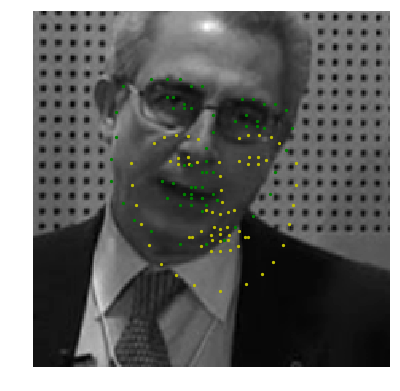

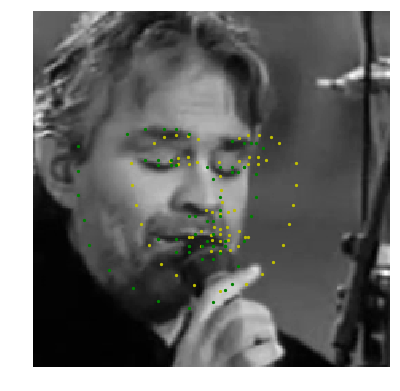

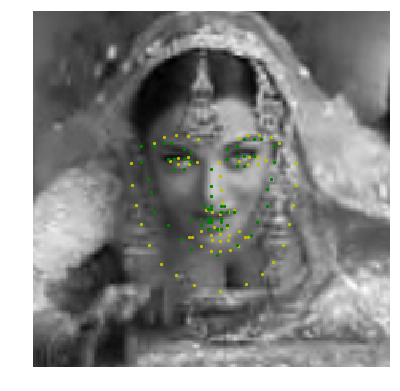

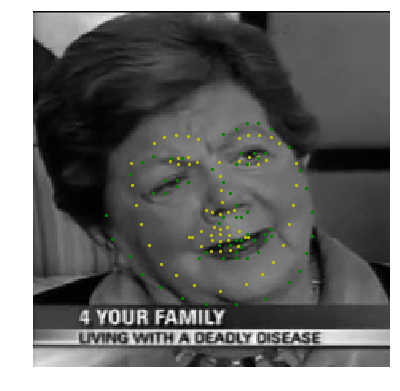

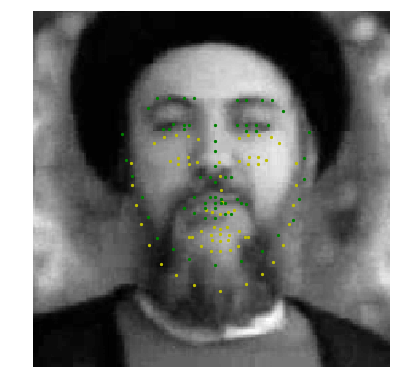

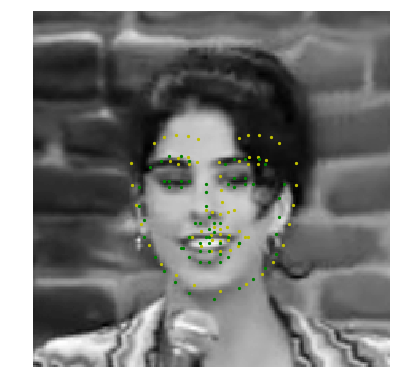

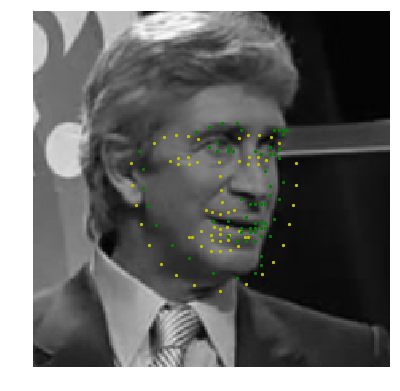

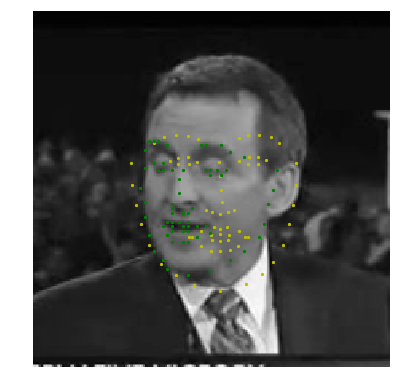

In [69]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, batch_size, gt_pts=None):

    for i in range(batch_size):
        plt.figure(figsize=(60,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        print(image.shape)
        predicted_key_pts = predicted_key_pts*(image.shape[0]/2)+(image.shape[0])
        print(predicted_key_pts)
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]  
            ground_truth_pts = (ground_truth_pts*(image.shape[0]/2))+(image.shape[0])
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, batch_size, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [60]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss(size_average=False)

optimizer = optim.RMSprop(net.parameters(), lr=0.01)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [61]:
import math

loss_over_time = [] # to track the loss as the network trains

def train_net(n_epochs):
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            print(loss.item())
            if batch_i % 27 == 26:    # print every 72 batches
                avg_loss = running_loss / 27
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}/{}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, math.ceil(len(transformed_dataset)/batch_size), avg_loss))
                running_loss = 0.0

    print('Finished Training')


In [62]:
# train the network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

557.8326416015625
1698255208448.0
1217569536.0
146371584.0
11340467200.0
5588466.5
45231144.0
4898739.5
17411946.0
22731.12890625
117503.5859375
143527.5
66340.09375
53850.0703125
34007.22265625
22652.21875
22849.427734375
20136.814453125
20842.376953125
35561.0625
28383.845703125
22052.0859375
9218.2373046875
2067.646728515625
2094.037841796875
481.1914367675781
369.8013916015625
Epoch: 1, Batch: 27/432, Avg. Loss: 63371606381.117805
274.6340637207031
227.08509826660156
183.68209838867188
118.7087631225586
165.02847290039062
157.45999145507812
107.28416442871094
110.021240234375
76.60938262939453
82.19166564941406
89.61646270751953
91.28907775878906
124.55549621582031
87.83899688720703
44.98930740356445
94.24879455566406
73.58368682861328
56.83625030517578
55.0994987487793
61.52487564086914
71.62996673583984
109.99266052246094
30.985267639160156
72.55439758300781
36.2332763671875
63.635398864746094
62.019351959228516
Epoch: 1, Batch: 54/432, Avg. Loss: 101.08658175998264
123.145286560

31.553691864013672
42.502357482910156
17.353769302368164
19.647785186767578
29.250362396240234
23.265140533447266
24.677406311035156
16.630033493041992
35.7471809387207
38.4527473449707
14.393054008483887
21.126073837280273
22.467695236206055
18.45245933532715
34.66815948486328
20.436115264892578
20.8216609954834
26.45728874206543
16.359859466552734
24.126197814941406
15.718156814575195
13.944005012512207
14.519466400146484
Epoch: 1, Batch: 432/432, Avg. Loss: 24.374438674361617
20.36534881591797
37.00938415527344
28.570964813232422
48.75010681152344
18.254989624023438
20.04979133605957
17.333986282348633
21.13108253479004
16.960948944091797
21.466163635253906
17.16550064086914
17.296640396118164
42.91408157348633
9.692279815673828
24.78852081298828
22.313941955566406
27.473587036132812
30.66710662841797
23.62868309020996
26.671255111694336
29.74241065979004
17.336923599243164
33.327980041503906
26.37150764465332
26.393829345703125
26.954551696777344
29.949312210083008
Epoch: 2, Batch:

17.278657913208008
Epoch: 2, Batch: 378/432, Avg. Loss: 25.133879114080358
28.067028045654297
32.702823638916016
24.366527557373047
12.032238006591797
17.307159423828125
19.18155288696289
20.443824768066406
30.565242767333984
15.69714641571045
11.241073608398438
10.82700252532959
18.678274154663086
14.196779251098633
26.29237174987793
12.41052532196045
20.367446899414062
14.102005004882812
8.46848201751709
20.543760299682617
23.306156158447266
18.264678955078125
10.915388107299805
28.777650833129883
18.515466690063477
16.826814651489258
29.159074783325195
24.627304077148438
Epoch: 2, Batch: 405/432, Avg. Loss: 19.55125179997197
14.772908210754395
17.905193328857422
20.337928771972656
42.20651626586914
42.75104904174805
22.85719871520996
12.4241943359375
12.556015014648438
22.783870697021484
32.82300567626953
43.68400573730469
19.708887100219727
23.111873626708984
27.849538803100586
20.666784286499023
22.780542373657227
33.454383850097656
24.845233917236328
12.21027946472168
10.02288246

22.56412124633789
9.40442943572998
11.008345603942871
8.043543815612793
17.666078567504883
36.25680923461914
18.859365463256836
13.01381778717041
12.271480560302734
Epoch: 3, Batch: 351/432, Avg. Loss: 19.551448751378942
13.830049514770508
9.805781364440918
25.36016082763672
9.399721145629883
10.961660385131836
15.791177749633789
15.447705268859863
26.04513931274414
17.61085319519043
10.34229850769043
14.857053756713867
15.974199295043945
10.955655097961426
30.86412811279297
44.246768951416016
15.296365737915039
10.774786949157715
13.244497299194336
16.882455825805664
15.42497730255127
14.750779151916504
23.730682373046875
21.453214645385742
26.244903564453125
26.356746673583984
19.9710693359375
28.337961196899414
Epoch: 3, Batch: 378/432, Avg. Loss: 18.66521453857422
35.49195098876953
35.50514221191406
13.721304893493652
9.457651138305664
47.34266662597656
22.55573844909668
23.014728546142578
17.36566925048828
8.307103157043457
14.092826843261719
17.237619400024414
11.61076545715332
1

9.829854011535645
9.717399597167969
15.600688934326172
12.195423126220703
6.943391799926758
25.934419631958008
13.692416191101074
13.969611167907715
13.078720092773438
23.51953125
22.00479507446289
23.246726989746094
12.825079917907715
17.226537704467773
20.018869400024414
15.594186782836914
Epoch: 4, Batch: 324/432, Avg. Loss: 15.961683520564327
11.180768966674805
13.952013969421387
11.365133285522461
22.48565673828125
13.149603843688965
9.497127532958984
16.633363723754883
17.72742462158203
9.569900512695312
13.539100646972656
10.713069915771484
11.144899368286133
18.274898529052734
10.191582679748535
37.260868072509766
8.6947660446167
18.220821380615234
15.82122802734375
12.91455078125
18.151485443115234
28.00776481628418
16.224891662597656
19.727664947509766
8.714917182922363
13.103859901428223
14.501388549804688
10.027312278747559
Epoch: 4, Batch: 351/432, Avg. Loss: 15.214669015672472
11.847505569458008
18.112411499023438
13.136611938476562
13.14013957977295
10.50903034210205
21.

9.564489364624023
16.662965774536133
21.226421356201172
10.60342788696289
16.2302188873291
16.401634216308594
10.664539337158203
8.721041679382324
20.996177673339844
14.364418029785156
17.040016174316406
6.716244220733643
28.41847038269043
10.626110076904297
14.56289291381836
12.770727157592773
9.984787940979004
11.355494499206543
14.36785888671875
24.262638092041016
10.158432006835938
19.408937454223633
15.655204772949219
16.891468048095703
Epoch: 5, Batch: 297/432, Avg. Loss: 15.137287192874485
19.336811065673828
13.617768287658691
9.6956205368042
19.986459732055664
14.5867338180542
28.07433319091797
11.923402786254883
9.051340103149414
22.545503616333008
12.699651718139648
9.964314460754395
25.880022048950195
19.0493221282959
18.269880294799805
17.986663818359375
11.403290748596191
38.373905181884766
15.543453216552734
17.379291534423828
8.069910049438477
39.39669418334961
5.232821941375732
12.353133201599121
9.783256530761719
10.287490844726562
6.324075222015381
12.711640357971191


34.110103607177734
Epoch: 6, Batch: 243/432, Avg. Loss: 18.6281448646828
11.626500129699707
11.305158615112305
6.54594612121582
11.391632080078125
13.6581392288208
11.890327453613281
9.517483711242676
16.066301345825195
20.516727447509766
8.202169418334961
9.620617866516113
14.37234115600586
25.35243797302246
13.344388961791992
17.60003089904785
12.857877731323242
18.048582077026367
28.140745162963867
8.677400588989258
12.526890754699707
6.704007148742676
13.267477035522461
25.49061393737793
12.78370189666748
20.240381240844727
16.34810447692871
10.096784591674805
Epoch: 6, Batch: 270/432, Avg. Loss: 14.303435890762895
6.531437397003174
7.69909143447876
8.963261604309082
21.164928436279297
16.653705596923828
21.56314468383789
21.25255584716797
23.296768188476562
15.258903503417969
17.867366790771484
12.534172058105469
15.251826286315918
13.57399845123291
12.269429206848145
24.55767822265625
28.157405853271484
17.668546676635742
9.94861888885498
15.480864524841309
18.62644386291504
27.5

11.836941719055176
15.415156364440918
12.208990097045898
14.646249771118164
10.953200340270996
15.817923545837402
11.777462005615234
12.527898788452148
7.589552879333496
Epoch: 7, Batch: 216/432, Avg. Loss: 14.376769224802652
26.068700790405273
8.552530288696289
10.497819900512695
13.834293365478516
12.649589538574219
19.682342529296875
23.320512771606445
10.64438247680664
11.918404579162598
12.32042121887207
17.89742660522461
11.327431678771973
15.466241836547852
10.945333480834961
12.840590476989746
14.256502151489258
9.782685279846191
13.003811836242676
21.31049919128418
18.368457794189453
13.04034423828125
14.271453857421875
20.037744522094727
19.386837005615234
11.047076225280762
15.549873352050781
22.839744567871094
Epoch: 7, Batch: 243/432, Avg. Loss: 15.217075983683268
18.793455123901367
13.574567794799805
10.145159721374512
10.495125770568848
22.493900299072266
8.143756866455078
25.08205223083496
15.018678665161133
20.880155563354492
15.287823677062988
36.37761688232422
14.817

8.32295036315918
16.373737335205078
15.08962345123291
15.77141284942627
17.868452072143555
6.37225341796875
10.519412994384766
8.995668411254883
9.035587310791016
17.14316749572754
6.9622368812561035
18.896455764770508
19.413652420043945
26.696170806884766
21.17630958557129
14.413971900939941
13.427902221679688
5.064672470092773
Epoch: 8, Batch: 189/432, Avg. Loss: 15.697717684286612
13.982855796813965
9.749176025390625
26.740633010864258
23.132675170898438
18.638744354248047
7.337211608886719
11.11650562286377
19.554622650146484
14.399033546447754
25.74956512451172
18.645015716552734
11.977023124694824
16.9702205657959
14.361236572265625
12.210795402526855
10.214289665222168
11.231779098510742
10.777095794677734
6.133101463317871
13.163378715515137
19.012901306152344
13.848684310913086
49.57048416137695
16.61383819580078
24.831832885742188
15.735706329345703
14.879003524780273
Epoch: 8, Batch: 216/432, Avg. Loss: 16.68805221275047
9.319700241088867
19.478225708007812
50.59004211425781

9.024979591369629
13.81527042388916
14.661030769348145
19.127126693725586
13.570222854614258
21.61532211303711
17.887300491333008
17.29909896850586
25.12388801574707
37.549041748046875
14.71935749053955
13.144822120666504
8.474074363708496
20.755741119384766
13.70946979522705
24.045785903930664
6.211458683013916
15.550558090209961
12.278563499450684
26.481904983520508
15.739195823669434
25.699804306030273
16.208309173583984
10.54890251159668
7.446169853210449
9.482318878173828
Epoch: 9, Batch: 162/432, Avg. Loss: 16.251667464220965
7.832823276519775
21.404491424560547
37.38018798828125
12.422635078430176
21.721885681152344
21.656837463378906
12.225911140441895
12.855499267578125
7.909861087799072
9.50186538696289
10.005477905273438
16.76435089111328
18.284687042236328
7.951522350311279
19.596738815307617
18.67854881286621
20.7393798828125
23.886940002441406
13.49999713897705
18.812463760375977
13.673171997070312
14.779899597167969
13.905111312866211
18.29060935974121
11.24618911743164


16.55845832824707
25.282882690429688
16.989606857299805
31.13971710205078
Epoch: 10, Batch: 108/432, Avg. Loss: 16.80709904211539
18.28091812133789
19.731229782104492
6.674238204956055
9.783625602722168
12.468791961669922
8.296016693115234
18.016372680664062
17.166486740112305
11.171982765197754
51.310089111328125
12.519968032836914
7.46089506149292
16.628421783447266
10.199213027954102
9.31447982788086
7.963091850280762
19.54210662841797
11.476856231689453
14.087533950805664
18.036399841308594
11.77473258972168
22.553741455078125
12.581207275390625
13.815468788146973
14.99990463256836
18.993633270263672
14.33375072479248
Epoch: 10, Batch: 135/432, Avg. Loss: 15.154857653158682
14.805530548095703
15.571296691894531
9.059012413024902
13.541386604309082
15.613945007324219
10.237183570861816
11.654770851135254
17.254087448120117
22.018898010253906
19.444644927978516
15.053257942199707
15.760640144348145
13.688194274902344
20.009397506713867
14.187807083129883
12.826800346374512
16.8826217

14.666850090026855
14.907289505004883
24.62027359008789
13.11019515991211
22.936382293701172
8.10315227508545
10.868114471435547
19.76569366455078
12.069601058959961
8.687915802001953
21.46601104736328
19.754730224609375
Epoch: 11, Batch: 81/432, Avg. Loss: 15.431617242318612
14.606620788574219
18.78428840637207
15.3999662399292
42.81300735473633
12.543553352355957
17.275850296020508
9.645707130432129
18.002992630004883
14.61281681060791
35.826080322265625
13.826708793640137
20.166358947753906
10.266018867492676
7.465656757354736
19.1259822845459
10.986978530883789
11.359131813049316
12.398348808288574
12.704148292541504
12.102252960205078
12.860809326171875
11.972393035888672
8.698899269104004
117.57516479492188
14.168007850646973
11.376678466796875
16.07427215576172
Epoch: 11, Batch: 108/432, Avg. Loss: 19.35698867727209
10.094411849975586
11.449119567871094
14.112192153930664
14.265253067016602
21.43849754333496
16.024354934692383
8.47414779663086
7.454103469848633
7.285989284515381

11.888077735900879
11.667719841003418
7.774456024169922
16.006702423095703
18.59071159362793
16.354808807373047
21.976940155029297
19.84598731994629
14.50308895111084
20.35675811767578
19.60458755493164
15.503384590148926
13.325006484985352
13.176023483276367
20.241825103759766
16.715917587280273
9.02293586730957
20.303415298461914
9.0035982131958
14.07422161102295
Epoch: 12, Batch: 54/432, Avg. Loss: 14.544597943623861
17.401382446289062
10.5805025100708
12.094502449035645
21.568904876708984
15.691978454589844
12.239237785339355
17.02268409729004
20.842910766601562
17.459535598754883
8.7805757522583
22.01222801208496
9.26358413696289
7.97153902053833
28.655109405517578
17.998197555541992
8.059179306030273
10.768450736999512
25.479970932006836
24.17824363708496
18.766769409179688
18.60100746154785
17.21776008605957
18.126970291137695
16.93001365661621
17.488094329833984
20.578393936157227
10.883455276489258
Epoch: 12, Batch: 81/432, Avg. Loss: 16.543006738026936
26.629066467285156
13.2

13.381468772888184
24.175832748413086
9.87834644317627
60.73862838745117
25.96700668334961
18.095888137817383
18.58867645263672
13.03852653503418
21.67823028564453
12.976062774658203
18.227025985717773
22.239952087402344
26.05779266357422
13.729501724243164
6.484529972076416
7.9974684715271
28.229839324951172
21.109149932861328
12.09373664855957
30.213106155395508
24.86378288269043
22.384071350097656
7.642888069152832
9.044692993164062
7.847047805786133
9.316884994506836
9.277239799499512
Epoch: 13, Batch: 27/432, Avg. Loss: 18.34360659563983
13.987974166870117
19.761905670166016
14.260162353515625
25.980819702148438
14.012289047241211
19.978435516357422
13.827847480773926
17.40642738342285
9.606532096862793
11.732081413269043
7.92495584487915
14.946941375732422
14.424188613891602
15.196550369262695
11.070274353027344
12.62241268157959
9.422818183898926
11.418231964111328
8.684440612792969
24.287330627441406
17.672334671020508
13.529352188110352
13.050716400146484
13.167451858520508
15

11.528497695922852
18.729961395263672
10.893607139587402
17.4848690032959
12.479965209960938
Epoch: 13, Batch: 405/432, Avg. Loss: 15.147954093085396
7.024591445922852
21.255165100097656
11.587316513061523
18.74490737915039
7.721889495849609
12.44810962677002
34.93605422973633
27.394899368286133
18.47521209716797
11.72213363647461
19.982410430908203
16.895429611206055
12.260641098022461
14.861517906188965
14.817678451538086
17.5916690826416
19.62839126586914
23.48823356628418
20.53296661376953
12.132287979125977
10.018136024475098
16.906084060668945
17.294689178466797
11.385201454162598
13.46878719329834
19.41091537475586
5.737463474273682
Epoch: 13, Batch: 432/432, Avg. Loss: 16.211954876228614
10.928510665893555
16.725595474243164
11.492392539978027
10.832545280456543
20.4915771484375
17.3298282623291
28.830032348632812
11.301855087280273
7.623297214508057
18.724084854125977
12.3836030960083
24.46929931640625
13.813618659973145
11.840824127197266
25.77875518798828
16.938459396362305


9.006047248840332
13.545382499694824
11.712459564208984
28.848033905029297
23.652929306030273
12.267773628234863
12.547931671142578
9.716383934020996
13.827902793884277
17.775259017944336
11.251455307006836
14.683605194091797
12.239376068115234
Epoch: 14, Batch: 378/432, Avg. Loss: 15.378588711773908
20.362346649169922
15.805774688720703
15.25834846496582
6.804157733917236
13.261004447937012
10.737845420837402
12.977863311767578
20.4288387298584
8.733476638793945
22.607311248779297
22.455293655395508
20.644943237304688
12.019685745239258
9.695242881774902
15.915201187133789
7.853698253631592
14.439301490783691
22.59393882751465
12.581357955932617
13.449666976928711
20.862987518310547
8.972010612487793
18.999698638916016
10.979350090026855
23.372833251953125
20.61631202697754
41.29814910888672
Epoch: 14, Batch: 405/432, Avg. Loss: 16.434319955331308
13.934732437133789
9.692792892456055
19.077905654907227
12.787367820739746
21.148176193237305
12.452962875366211
16.006240844726562
30.7775

KeyboardInterrupt: 

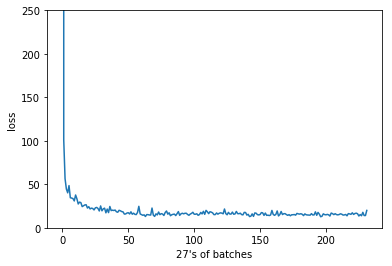

In [63]:
# visualize the loss as the network trained
plt.plot(loss_over_time)
plt.xlabel('27\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 250) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [66]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


(224, 224, 1)
tensor([[-1.3899, -1.1694],
        [-1.3899, -1.0506],
        [-1.3661, -0.9556],
        [-1.3423, -0.8369],
        [-1.3185, -0.7419],
        [-1.2470, -0.6706],
        [-1.2232, -0.6231],
        [-1.1994, -0.5756],
        [-1.0804, -0.5756],
        [-0.9613, -0.5993],
        [-0.8185, -0.6468],
        [-0.7232, -0.7181],
        [-0.6280, -0.7894],
        [-0.5804, -0.9081],
        [-0.5804, -1.0031],
        [-0.5565, -1.1219],
        [-0.5565, -1.2406],
        [-1.3899, -1.3119],
        [-1.3899, -1.3594],
        [-1.3661, -1.4069],
        [-1.3185, -1.3831],
        [-1.2708, -1.3594],
        [-1.0804, -1.3831],
        [-1.0089, -1.4307],
        [-0.9613, -1.4544],
        [-0.8661, -1.4069],
        [-0.7708, -1.3594],
        [-1.1994, -1.2406],
        [-1.1994, -1.1694],
        [-1.2232, -1.0981],
        [-1.2232, -1.0506],
        [-1.2232, -0.9794],
        [-1.2232, -0.9794],
        [-1.1994, -0.9794],
        [-1.1280, -0.9794],
      

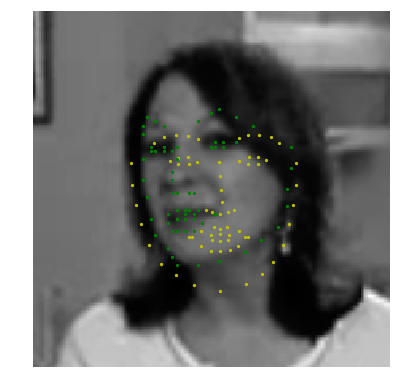

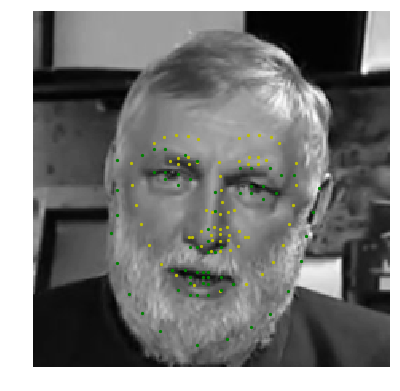

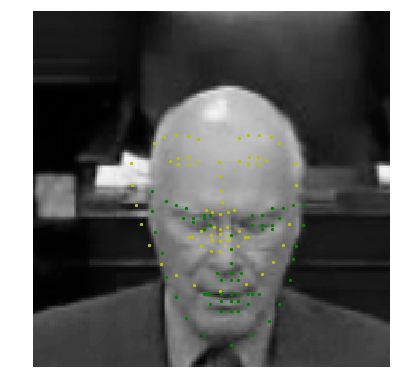

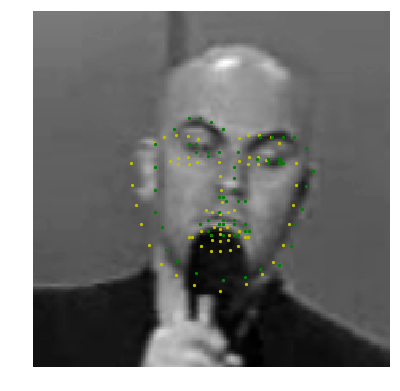

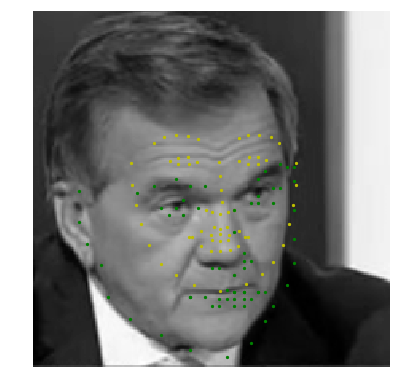

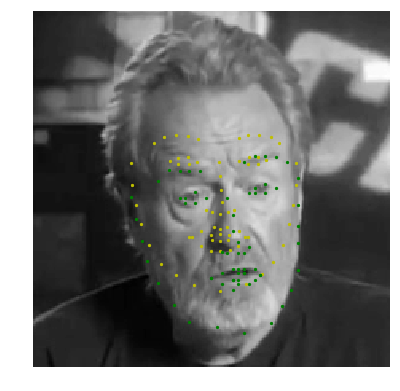

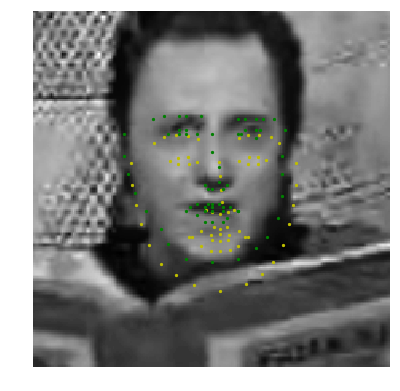

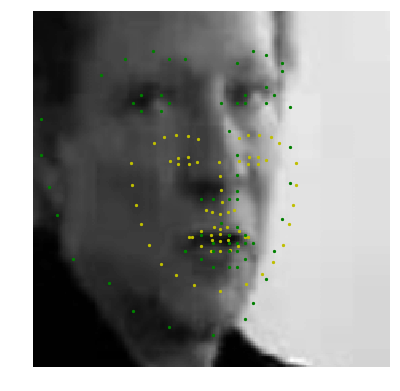

In [67]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, batch_size, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [41]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.12999755 -0.03345641 -0.21452075 -0.09482409 -0.05326112]
 [-0.06171801 -0.18371809 -0.15955721 -0.11501199 -0.00862228]
 [-0.15854567 -0.15529896 -0.17144009 -0.06227745 -0.08536284]
 [-0.07054334 -0.12716338 -0.04595468 -0.11278088 -0.05903669]
 [-0.18525013 -0.00160807 -0.14184919 -0.19915801 -0.18129006]]
(5, 5)


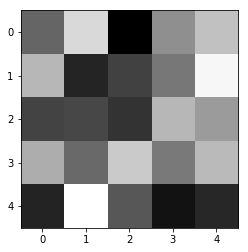

In [43]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!